In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from data_processing import make_classification, fetch_covtype, create_dataset
from MLP import MLP
from rainbow_MLP import rainbow_MLP
from testing import test
from torch.utils.data import DataLoader
from training import train
from utils import check_normalisation, plot_results_2D, check_alignement, Marchenko_Pastur, measure_covariance_alignment_quality_

## Génération des données

In [2]:
X, y = make_classification(n_samples=5000, n_features=10, n_redundant=0, n_informative=10, n_classes=4)
#X, y = fetch_covtype()

train_data, val_data, test_data = create_dataset(X, y, normalize = True, prop_val = 0.7, prop_test = 0.15)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Entraînement du modèle cible

True
[INFO] training using cuda:1.
Initial roc_auc_score (validation): 0.4581845107542968
Epoch [1/10], Loss_error (train): 0.7040, Roc_auc_score (validation): 0.9717891170205829
Epoch [2/10], Loss_error (train): 0.3217, Roc_auc_score (validation): 0.9775559122508515
Epoch [3/10], Loss_error (train): 0.2659, Roc_auc_score (validation): 0.9837038228801913
Epoch [4/10], Loss_error (train): 0.2451, Roc_auc_score (validation): 0.9826963471093763
Epoch [5/10], Loss_error (train): 0.2305, Roc_auc_score (validation): 0.9821315637177023
Epoch [6/10], Loss_error (train): 0.2268, Roc_auc_score (validation): 0.9762949346211669
Epoch [7/10], Loss_error (train): 0.2068, Roc_auc_score (validation): 0.985165337000988
Epoch [8/10], Loss_error (train): 0.1820, Roc_auc_score (validation): 0.9867782684389325
Epoch [9/10], Loss_error (train): 0.1630, Roc_auc_score (validation): 0.9857869519878956
Epoch [10/10], Loss_error (train): 0.1599, Roc_auc_score (validation): 0.979698605979018


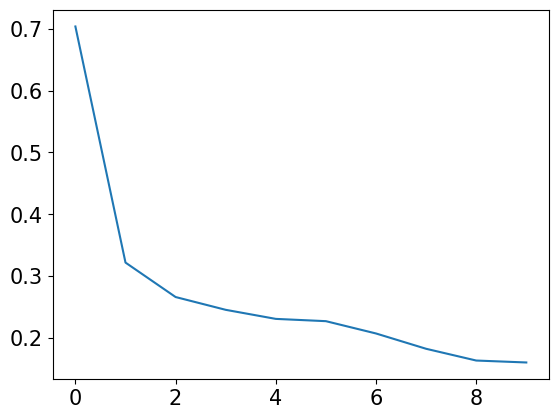

Test roc_auc_score:  0.9815082742989848 .


In [32]:
target_layer_size = 2000
hidden_layer_sizes = [target_layer_size, target_layer_size, target_layer_size, np.max(train_data.tensors[1].numpy())+1]
target_model = MLP(train_data[0][0].shape[0], hidden_layer_sizes, batch_norm = True)

Nb_epochs = 10

print(torch.cuda.is_available())
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
print("[INFO] training using {}.".format(DEVICE))

target_model.to(DEVICE)

train(target_model, train_dataloader, val_dataloader, Nb_epochs, len(train_data), DEVICE, text = True, plot = True)
_ = test(target_model, test_dataloader, len(test_data), DEVICE)

## Convergence des activations

Alignements pour un réseau de largeur  62 .
Alignements pour un réseau de largeur  125 .
Alignements pour un réseau de largeur  250 .
Alignements pour un réseau de largeur  500 .
Alignements pour un réseau de largeur  1000 .


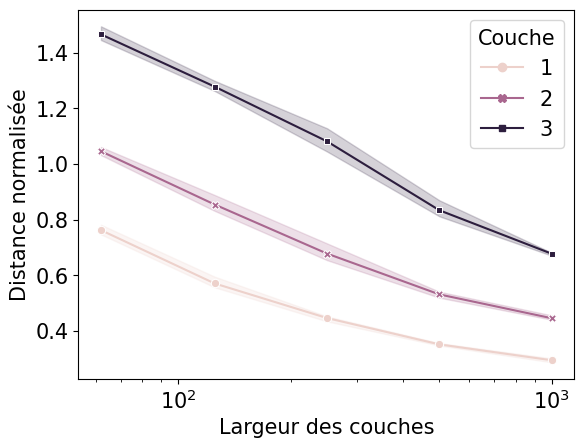

In [33]:
results_activations = pd.DataFrame(columns=['Couche', 'Largeur des couches', 'Distance normalisée', 'Run'])

for i in range(5, 0, -1):
    layer_size = int(target_layer_size/2**i)
    print("Alignements pour un réseau de largeur ", layer_size, ".")
    hidden_layer_sizes = [layer_size, layer_size, layer_size, np.max(train_data.tensors[1].numpy())+1]
    for run in range(3):
        model = MLP(train_data[0][0].shape[0], hidden_layer_sizes, batch_norm = True)
        model.to(DEVICE)
        train(model, train_dataloader, val_dataloader, Nb_epochs, len(train_data), DEVICE, text = False, plot = False) 
        alignment_quality = model.get_alignment(X, target_model,
                                    DEVICE, plot_alignement=-1, prop_train=.7)[1]
        for j in range(len(hidden_layer_sizes)-1):
            results_activations = pd.concat([results_activations, pd.DataFrame([[j+1, layer_size, alignment_quality[j][0],
                                        run]], columns=results_activations.columns)], ignore_index=True)

sns.lineplot(data=results_activations, x="Largeur des couches", y="Distance normalisée", hue="Couche",
             style="Couche", markers=True, dashes=False)
plt.xscale('log')

## Convergence des covariances

On commence par estimer les covariances limites pour la première et la deuxième couches cachées :

In [29]:
limit_covariance_1 = 0
limit_covariance_2 = 0

for run in range(10):
    print('Run : ', run, '.')
    
    model = MLP(train_data[0][0].shape[0], hidden_layer_sizes, batch_norm = True)
    model.to(DEVICE)

    train(model, train_dataloader, val_dataloader, Nb_epochs, len(train_data), DEVICE, text = False, plot = False)
    
    aligned_covariances = model.get_aligned_covariances(X, target_model, DEVICE)
    limit_covariance_1 += aligned_covariances[0]
    limit_covariance_2 += aligned_covariances[1]

limit_covariance_1 /= 10
limit_covariance_2 /= 10

Run :  0 .
Run :  1 .
Run :  2 .
Run :  3 .
Run :  4 .
Run :  5 .
Run :  6 .
Run :  7 .
Run :  8 .
Run :  9 .


Alignement pour un réseau de largeur  62 .
Run :  0 .
Run :  1 .
Run :  2 .
Run :  3 .
Run :  4 .
Run :  5 .
Run :  6 .
Run :  7 .
Run :  8 .
Run :  9 .
Alignement pour un réseau de largeur  125 .
Run :  0 .
Run :  1 .
Run :  2 .
Run :  3 .
Run :  4 .
Run :  5 .
Run :  6 .
Run :  7 .
Run :  8 .
Run :  9 .
Alignement pour un réseau de largeur  250 .
Run :  0 .
Run :  1 .
Run :  2 .
Run :  3 .
Run :  4 .
Run :  5 .
Run :  6 .
Run :  7 .
Run :  8 .
Run :  9 .
Alignement pour un réseau de largeur  500 .
Run :  0 .
Run :  1 .
Run :  2 .
Run :  3 .
Run :  4 .
Run :  5 .
Run :  6 .
Run :  7 .
Run :  8 .
Run :  9 .
Alignement pour un réseau de largeur  1000 .
Run :  0 .
Run :  1 .
Run :  2 .
Run :  3 .
Run :  4 .
Run :  5 .
Run :  6 .
Run :  7 .
Run :  8 .
Run :  9 .


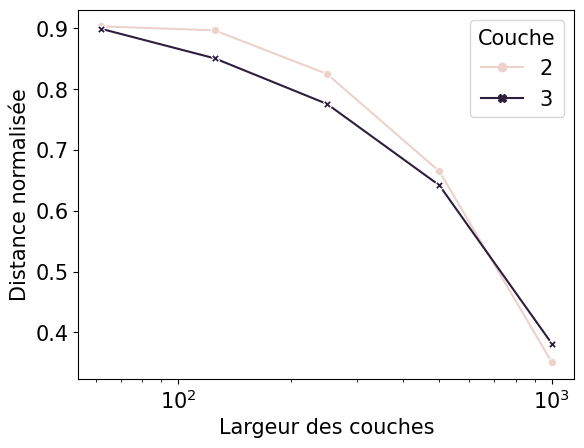

In [30]:
results_covariances = pd.DataFrame(columns=['Couche', 'Largeur des couches', 'Distance normalisée'])

for i in range(5, 0, -1):
    layer_size = int(target_layer_size/2**i)
    print("Alignement pour un réseau de largeur ", layer_size, ".")
    hidden_layer_sizes = [layer_size, layer_size, layer_size, np.max(train_data.tensors[1].numpy())+1]
    covariance_1_estimate = 0
    covariance_2_estimate = 0
    for run in range(10):
        print('Run : ', run, '.')
        model = MLP(train_data[0][0].shape[0], hidden_layer_sizes, batch_norm = True)
        model.to(DEVICE)
        
        train(model, train_dataloader, val_dataloader, Nb_epochs, len(train_data), DEVICE, text = False, plot = False) 
        aligned_covariances = model.get_aligned_covariances(X, target_model, DEVICE)
        covariance_1_estimate += aligned_covariances[0]
        covariance_2_estimate += aligned_covariances[1]
    covariance_1_estimate /= 10
    covariance_2_estimate /= 10
    
    results_covariances = pd.concat([results_covariances, pd.DataFrame([[2, layer_size,
                                measure_covariance_alignment_quality_(covariance_1_estimate, limit_covariance_1)]],
                                columns=results_covariances.columns)], ignore_index=True)
    results_covariances = pd.concat([results_covariances, pd.DataFrame([[3, layer_size,
                                measure_covariance_alignment_quality_(covariance_2_estimate, limit_covariance_2)]],
                                columns=results_covariances.columns)], ignore_index=True)

sns.lineplot(data=results_covariances, x="Largeur des couches", y="Distance normalisée", hue="Couche",
             style="Couche", markers=True, dashes=False)
plt.xscale('log')